In [1]:
from tensorflow.keras.utils import load_img, img_to_array, plot_model
import numpy as np

from tensorflow.keras.models import load_model, Model
from kerasncp.tf import LTCCell
from kerasncp.wirings import NCP
import matplotlib.pyplot as plt
import cv2
import pydot
import seaborn as sns

from constants import PROCESSED_IMG_SHAPE
from keras.layers import (
    RNN,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    InputLayer,
    Reshape,
)
from keras.models import Model, Sequential

In [2]:

img_path = './images/Screenshot.png'
img = load_img(img_path, target_size=(144,320),color_mode="grayscale")
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
print(img_tensor.shape)

(1, 144, 320, 1)


In [7]:
model = load_model("./models/cnn_ncp_model-0.052588.h5", custom_objects={"LTCCell": LTCCell})
activation_model = Model(inputs=model.inputs, outputs=model.layers[0].output)
activation = activation_model(img_tensor)

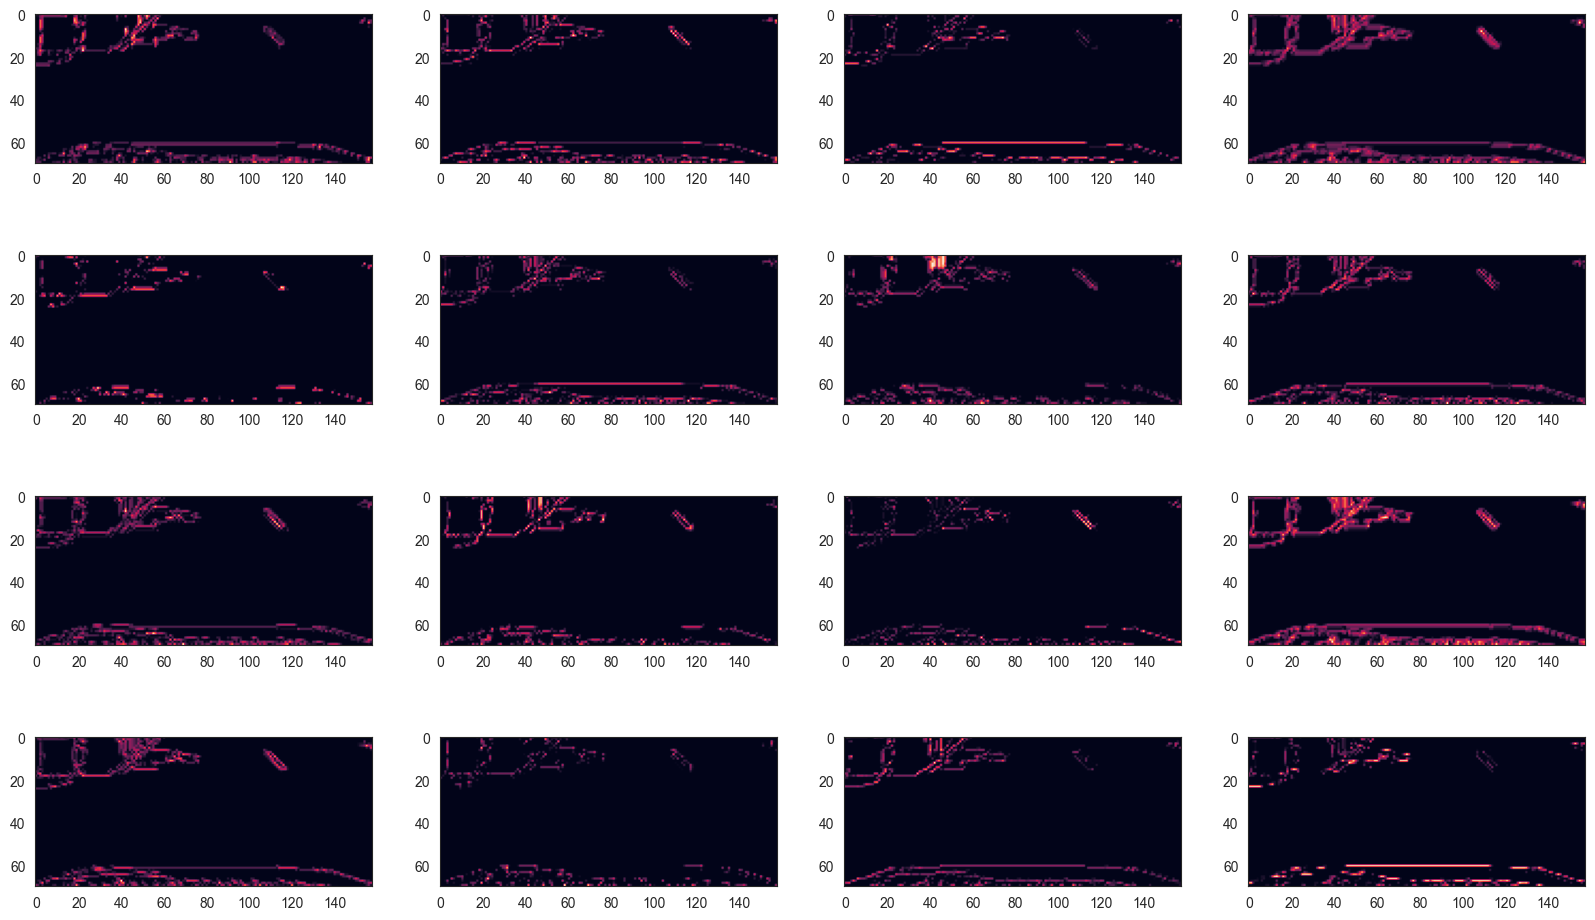

In [8]:
plt.figure(figsize=(20,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(activation[0,:,:,i])
plt.show()

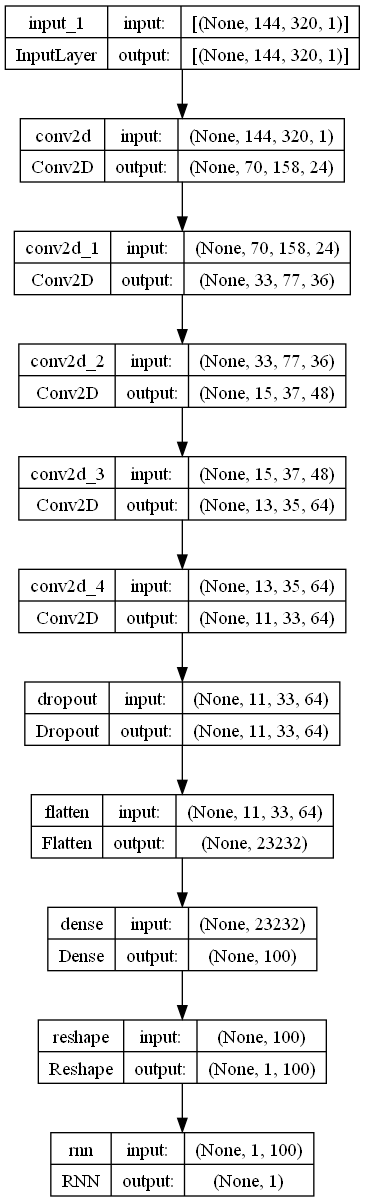

In [51]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [75]:
# Create a new graph with horizontal layout and colors
graph = pydot.Dot(graph_type='graph', rankdir='LR', bgcolor='white')

# Iterate through each layer in the model
for layer in model.layers:
    if isinstance(layer, Model):
        # For submodels (e.g., recurrent layers), add subgraph clusters
        subgraph = pydot.Cluster(str(id(layer)), label=layer.name)
        for sub_layer in layer.layers:
            subgraph.add_node(pydot.Node(sub_layer.name))
        graph.add_subgraph(subgraph)
    else:
        # For regular layers, add nodes with layer names
        graph.add_node(pydot.Node(layer.name))

# Add edges to connect layers
for i in range(1, len(model.layers)):
    graph.add_edge(pydot.Edge(model.layers[i-1].name, model.layers[i].name))

# Save the visualization to a file
graph.write_png('images/model_plot.png')


In [70]:
LTCCell = model.layers[9].get_config()['cell']
print(LTCCell)
print(LTCCell['config'])
sensory_adjacency_matrix = np.array(LTCCell['config']['sensory_adjacency_matrix'])
print(sensory_adjacency_matrix.shape)


{'class_name': 'Custom>LTCCell', 'config': {'adjacency_matrix': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1, 0, -1, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, -1, 0, 0, -1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1, -1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0,

In [14]:
wiring = NCP(
        inter_neurons=12,  # Number of inter neurons
        command_neurons=8,  # Number of command neurons
        motor_neurons=1,  # Number of motor neurons
        sensory_fanout=4,  # How many outgoing synapses has each sensory neuron
        inter_fanout=4,  # How many outgoing synapses has each inter neuron
        recurrent_command_synapses=4,  # Now many recurrent synapses are in the
        # command neuron layer
        motor_fanin=6,  # How many incoming synapses has each motor neuron
    )

ncp_cell = LTCCell(wiring)
model = Sequential()
model.add(InputLayer(input_shape=PROCESSED_IMG_SHAPE))
model.add(Conv2D(24, 5, 2, activation='relu'))
model.add(Conv2D(36, 5, 2, activation='relu'))
model.add(Conv2D(48, 5, 2, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Reshape((1, -1)))
model.add(RNN(ncp_cell, unroll=True))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 158, 24)       624       
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 77, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 37, 48)        43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 35, 64)        27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 33, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 11, 33, 64)        0         
                                                                 
 flatten (Flatten)           (None, 23232)             0

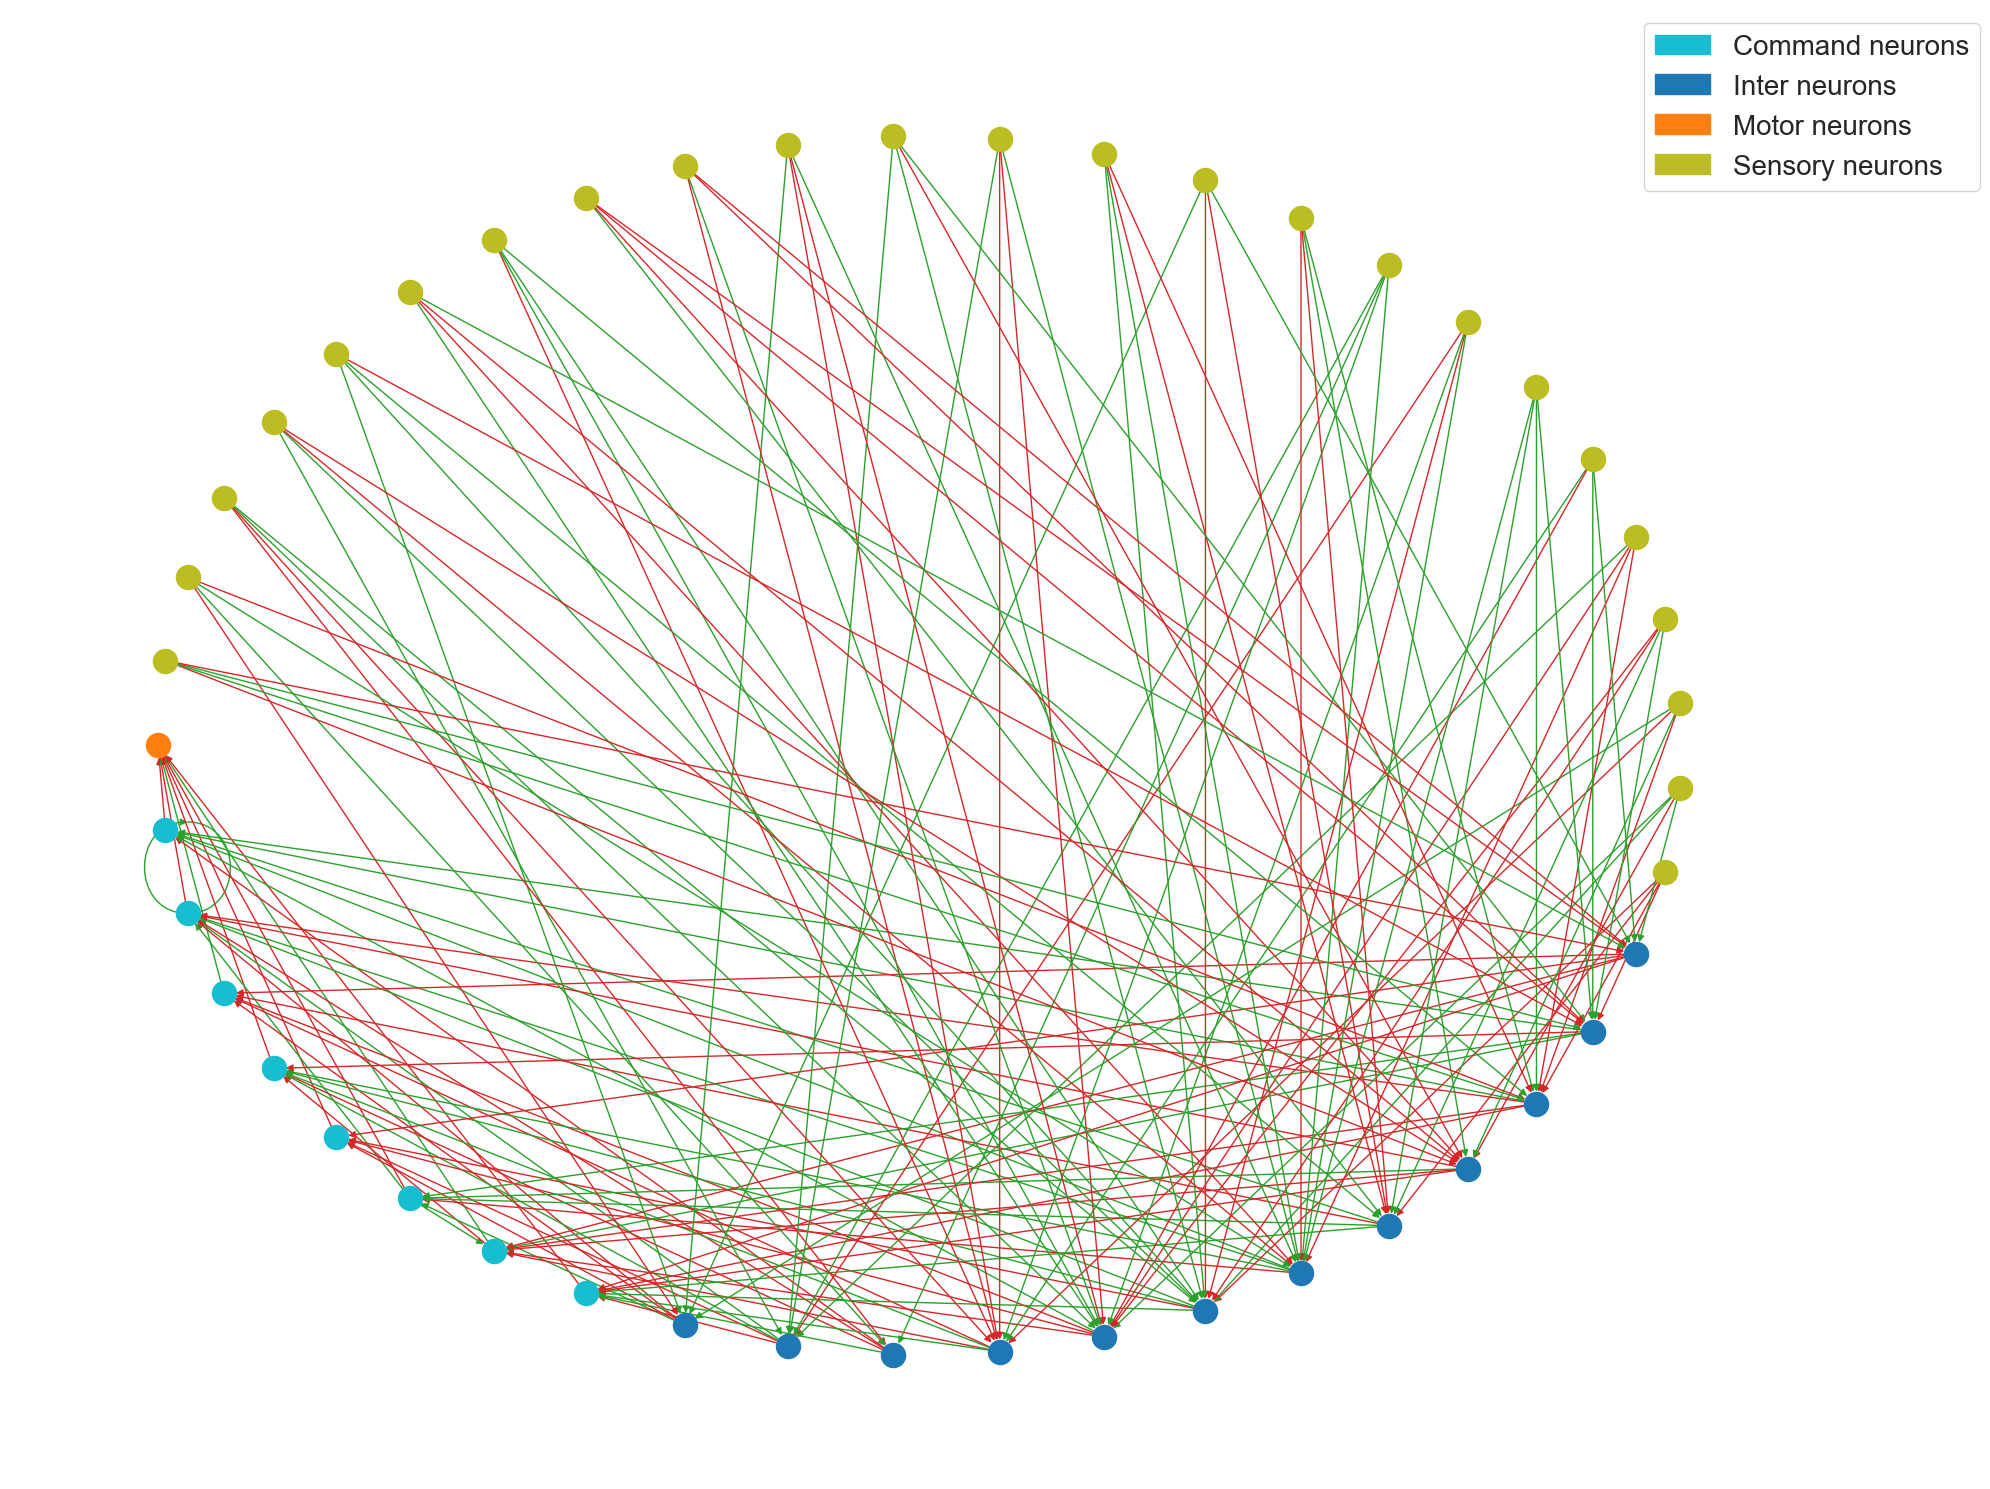

In [16]:
sns.set_style("white")
plt.figure(figsize=(20, 15))
legend_handles = ncp_cell.draw_graph(layout='shell',neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1), fontsize=20)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()